<a href="https://colab.research.google.com/github/marcocaramanti/MLPNS_MCaramanti/blob/main/linearRegression/FittingLineToGRBAfterglows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods. 

Notes: 

a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    
  **TL;DR: we measure a quantity named magnitude over time, which is an inverse logaritmic measure of brightness of the GRB, and which is expected to change it roughly linearly with the logarithm of time.**

_About GRB Afterglows_

*Gamma-ray bursts (GRBs) are bright X-ray and gamma-ray flashes observed in the sky, emitted by distant extragalactic sources. They are associated with the creation or merging of neutron stars or black holes; processes which result in an explosive outburst of material moving incredibly close to the speed of light [ref](https://www.mpg.de/16999277/0607-kern-gammarayburst-153865-x#:~:text=It%20was%20this%20afterglow%20emission,the%20form%20of%20synchrotron%20photons). Long after the initial burst of gamma rays has subsided, gamma ray bursts (GRBs) are still observable at less energetic wavelengths. Although no formal definition exists, this smoothly varying, lower energy radiation that may be visible for several days following the GRB itself, is usually referred to as the GRB afterglow.*


    
  **Details**: *The light that we measure from these explosions changes over time, so we can study its time series. The change in light is exponential, not linear, but if we take the logarithm of the light, that chance may be linear, since the logarithm is the inverse of exponent. The logarithm of the light flux is called magnitude in astronomy. A line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process.*
    
*It is believed that the afterglow originates in the external shock produced as the blast wave from the explosion collides with and sweeps up material in the surrounding interstellar medium. The emission is synchrotron emission produced when electrons are accelerated in the presence of a magnetic field. The successive afterglows at progressively lower wavelengths (X-ray, optical, radio) result naturally as the expanding shock wave sweeps up more and more material causing it to slow down and lose energy.*

*X-ray afterglows have been observed for all GRBs, but only about 50% of GRBs also exhibit afterglows at optical and radio wavelengths [ref](https://astronomy.swin.edu.au/cosmos/G/gamma+ray+burst+afterglow)*

  *In reality, the correct model is a  broken powerlaw: the slope of the line "breaks" or changes, at some point in time. But this exercise is about fitting lines. But in the end we will use MCMC and find out which model is better*

# initial imports

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
%pylab inline

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
# pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA22_FBianco/master/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


# Task 1: Read and prepare the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

find the link to the *raw* input file on github in the HW1 folder https://github.com/fedhere/MLTSA_FBianco/tree/master/HW1

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/MLPNS_FBianco/main/linearRegression/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


## Create the log-time variable

We will fit a line in log space. The magnitude column I gave you is the logarithm (base 10) of the flus so that is already available. Create a logarithm base 10 of the time variable

(Fitting a line in log-log space corresponds to fitting a powerlaw y=x^a in natural space. Note: we mean logbase 10, use ```numpy.log10()```)

If you have trouble with this look at this gist https://gist.github.com/fedhere/42956d318347def627f6ad750c3eee9a


In [3]:
grbAG["logtime"] = np.log10(grbAG.time)
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. 

The information about the photometric band is stored in the variable ```grbAG.filter```. If I wanted to retrieve all magnitudes for filter 'V' I would do ```grbAG.loc[grbAG["filter"] == f, "mag"]```.

Plot the data with different colors for different photometric bands. 

Use pl.errorbar to display the uncertainties in the data - if you do not know how to use pl.errorbar you can symply type

```pl.errorbar?``` in a cell to retrieve the help

In [ ]:
pl.errorbar?

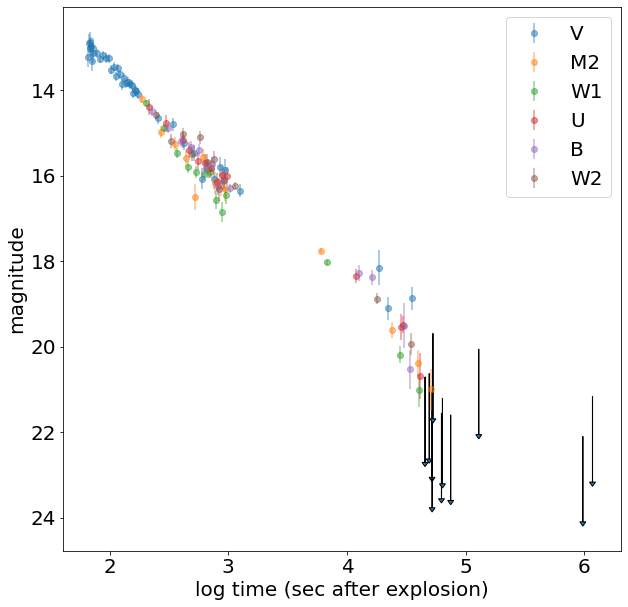

In [6]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"],
                grbAG.loc[grbAG["filter"] == f, "magerr"],
                marker = "o", linestyle = "None", alpha = 0.5,
                label = str(f));

        # oppure basta fmt = "o" per avere i punti e non linee che li uniscono
        # alpha = 0.5 aumenta la trasparenza. Utile quando abbiamo punti che
        # si sovrappongono
    
    

# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k');

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.gca().invert_yaxis()
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);



Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. 

## Clean the data: Remove upper limits
This data includes upper limits which I plotted as downward errors. upper and lower limits (technically called "censored data" are extremely hard to deal with in modeling). For now, lets just remove them. 

To remove the upper limits you can "broadcast" the data: in pandas that looks like 

```grbAG.loc[grbAG.upperlimit == 0]```

If you do not know how to remove selected rows from a dataframe based on a condition look at this gist https://gist.github.com/fedhere/e9cd67d9dc0357ee547e03a12ceb4719

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```. 


# Task 2: Fit models to data
## Task 2a: Solve using the Normal Equation

You can use the code I put in the slides for this - you can copy and paste it but you will learn most if you try type it down and make sure you understand it line by line!!

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [7]:
grbAGnu = grbAG[grbAG.upperlimit == 0]
grbAGnu.upperlimit.unique()


array([0])

In [8]:
x = grbAGnu.logtime # what is your exogenous variable?

X = np.c_[np.ones((len(grbAGnu), 1)),
          x]

# np.c_ è la funzione concatenate. Serve per concatenare array

y = grbAGnu.mag

print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [9]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
                                           
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))
# *theta_best passa il puntatore alla variabile

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## Task 2b: Fit a line to the data with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.





In [10]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression

#sklearn is an object oriented package. You will call the function which will create a model (model selection) then fit it to the data separately (model fitting)

lr = LinearRegression()
lr.fit(X, y)
       
#this will create new properties of the model instance: the intercept and coefficients!

print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


## Optional Task 2c: Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [11]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(x, intercept, slope):
    return slope * x + intercept

def l1(args, x, y):
    a, b = args # qui spacchetto la tupla degli argomenti
    return np.abs(y-line(x,a,b)).sum() #see slides!


initialGuess = (10, 1) #this can be important, a bad choice can get us stuck in a local minimum. But for this simple problem we can just guess whaetever
# Se succes: False provare altri valori iniziali

l1Solution = minimize(l1, initialGuess, args=(x, y))
# l1Solution è una classe. A noi interessa l'attributo x che contiene il
# best fit
print(l1Solution) # Esploriamo gli attributi di questa classe
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.303317772383874
        x: [ 8.225e+00  2.641e+00]
      nit: 17
      jac: [-1.359e-01 -2.094e+00]
 hess_inv: [[ 1.935e-04 -4.675e-05]
            [-4.675e-05  1.132e-05]]
     nfev: 391
     njev: 125

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [12]:
# Proviamo con L2

def l2(args, x, y):
    a, b = args
    return np.sum(( line(x, a, b) - y)**2) #see slides!

    


initialGuess = (10, 1) #this can be important, a bad choice can get us stuck in a local minimum. But for this simple problem we can just guess whaetever

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L1: " + 
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.82598750072551
        x: [ 8.583e+00  2.512e+00]
      nit: 4
      jac: [ 0.000e+00  2.384e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64



## Optional task 2d: Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the Pearson's $\chi^2$ (chi squared) function as your objective function. The $\chi^2$ is the distance between prediction and truth, divided by the uncertainty (sigma squares) see slides or see slides or https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#:~:text=10%20References-,Definition,differs%20from%20a%20theoretical%20distribution.

In [13]:
def chi2(args, x, y, s):
    a, b = args
    return np.sum((y - line(x,a,b))**2 / s**2) #see notes

s = grbAGnu.magerr.values
# assign the uncertainties to s. Its the column names "magerr"

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 317.420669801309
        x: [ 8.599e+00  2.480e+00]
      nit: 4
      jac: [-3.815e-06  0.000e+00]
 hess_inv: [[ 1.559e-03 -5.429e-04]
            [-5.429e-04  2.017e-04]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Task 3: Plot all the solutions

To do this best, you can create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.

If you do not know how to define a function look here. https://gist.github.com/fedhere/babc8d20533acb9288caf097138825bc


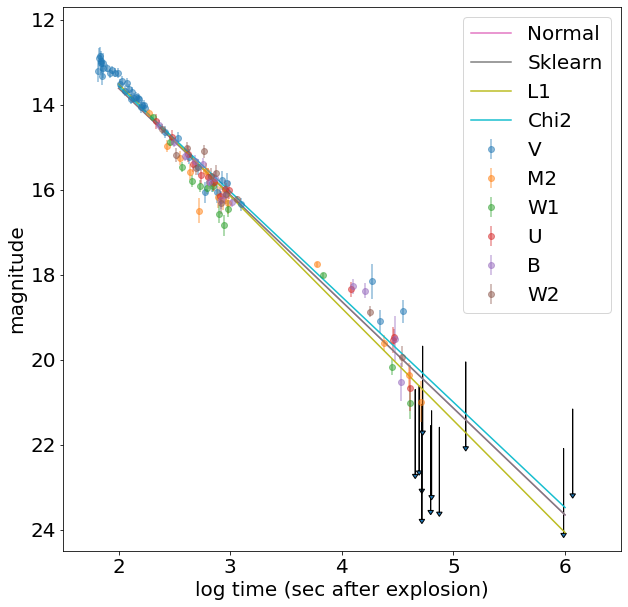

In [14]:
def plotline(ax, intercept, slope, str):
    x = np.array([2, 6])
    ax.plot(x, slope * x + intercept, label = str)


ax = pl.figure(figsize=(10,10)).add_subplot(111)

# plot the datapoints as above as errorbars
# Da qui copiamo il codice di prima

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"],
                grbAG.loc[grbAG["filter"] == f, "magerr"],
                marker = "o", linestyle = "None", alpha = 0.5,
                label = str(f));

        # oppure basta fmt = "o" per avere i punti e non linee che li uniscono
        # alpha = 0.5 aumenta la trasparenza. Utile quando abbiamo punti che
        # si sovrappongono
    
    

# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k');

# Fine copia

#plot the models

#normal equation
plotline(ax, theta_best[0], theta_best[1], "Normal")
         
#sklearn
plotline(ax, lr.intercept_, lr.coef_[1], "Sklearn")
         
#minimize L1
plotline(ax, l1Solution.x[0], l1Solution.x[1], "L1")
         
#minimize chi2
plotline(ax, chi2Solution.x[0], chi2Solution.x[1], "Chi2")

# pl.ylim(...
        
pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

Text(0.5, 0, 'log time (sec after explosion)')

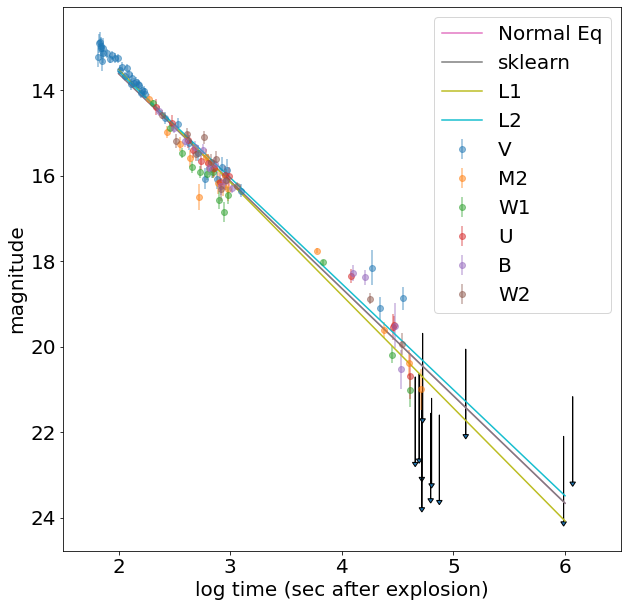

In [15]:
# Soluzione "ufficiale" del plot

def plotline(x, intercept, slope, legend=None, symbol="-", ax=ax):
  ax.plot(x, line(x, intercept, slope), ls=symbol, label=legend)

newx = np.array([2, 6])
# Come x per plottare una retta bastano due punti
ax = pl.figure(figsize=(10,10)).add_subplot(111)

# plot the datapoints as above as errorbars
for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"],
                grbAG.loc[grbAG["filter"] == f, "magerr"],
                marker = "o", linestyle = "None", alpha = 0.5,
                label = str(f));

        # oppure basta fmt = "o" per avere i punti e non linee che li uniscono
        # alpha = 0.5 aumenta la trasparenza. Utile quando abbiamo punti che
        # si sovrappongono

# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k');
          

plotline(newx, *theta_best, ax=ax, legend="Normal Eq")
# l'asterisco spacchetta i dati
plotline(newx, lr.intercept_, lr.coef_[1], ax=ax, legend="sklearn")
plotline(newx, *l1Solution.x, ax=ax, legend="L1")
plotline(newx, *chi2Solution.x, ax=ax, legend="L2")

pl.legend()

pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.gca().invert_yaxis()

pl.xlabel("log time (sec after explosion)", fontsize=20)

# Model validation

In [16]:
# Facciamo la validation
# Si prendono i dati a caso nel subset per evitare bias. C'è una funzione 
# già pronta per farlo

from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(x, y, s, test_size=0.25, random_state = 42)

chi2Solution = minimize(chi2, initialGuess, args=(x_train, y_train, s_train))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 240.77095739586136
        x: [ 8.685e+00  2.450e+00]
      nit: 4
      jac: [-1.907e-06  7.629e-06]
 hess_inv: [[ 1.896e-03 -6.411e-04]
            [-6.411e-04  2.318e-04]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.68, intercept 2.45


In [18]:
# Metrica
# Possiamo usare ad esempio L2 come metrica di test. Assicurarsi di calcolarla
# sui test values
l2(chi2Solution.x, x_test, y_test), l2(l2Solution.x, x_test, y_test)

(2.792722002650649, 2.371095288203658)

# Day 2

In [19]:
# Vogliamo implementare MCMC
# Il pacchetto però non è disponibile in colab: dobbiamo installarlo

!pip install emcee

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 KB 4.7 MB/s eta 0:00:00


In [20]:
import emcee

In [21]:
# Installiamo poi un pacchetto per visualizzazioni

!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import corner

Ricordiamo il Bayes theorem
$$ p(a,b | y) \sim p(y | a,b) * p(a,b) $$
In realtà noi passiamo ai log
$$ \log(\text{posterior}) \sim \log(\text{prior}) + \log(\text{likelihood})$$

In [23]:
# Vogliamo massimizzare il log_posterior

def log_prior(theta):
  slope, intercept = theta # Estraggo i parametri dalla tupla

  # Da motivi fisici so che la slope e l'intercetta devono essere positivi
  if slope > 0 and intercept > 0:
    return 0
  # Questo è un semi-informative prior, serve solo per limitare il parameter
  # space, quindi posso ritornare qualsiasi cosa

  # Dato che voglio massimizzare il posterior, se sono fuori dal prior ritorno 
  # qualcosa di molto piccolo che "non può essere battuto": - infinito
  return -np.inf

def log_likelihood(theta, x, y, yerr):
  # È la prob dei dati dato il modello. È lo stesso della target function
  # che abbiamo usato ieri
  # Vogliamo ritornare il chi2

  slope, intercept = theta
  return -np.sum(((line(intercept, slope, x) - y)**2) / yerr**2)


In [24]:
def log_probability(theta, x, y, yerr):
  # Credo che questo sia il posterior, no?

  lp = log_prior(theta)
  if not np.isfinite(lp):
  # cioè se il prior è -inf ritorna -inf: zona non permessa del parameter space
    return -np.inf
  return lp + log_likelihood(theta, x, y, yerr)

In [57]:
np.random.seed(324)

ig = [1, 10] # initial guess
nwalkers = 32 # numero catene in parallelo
ndim = len(ig) # numero dimensioni problema = numero parametri

# Ora dobbiamo una posizione iniziale a ogni catena. Vogliamo dare posizioni
# diverse ma simile alla guess iniziale. Introdurremo un po' di rumore
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)
pos.shape

(32, 2)

In [26]:
# Anche qui il pacchetto funziona instanziando una classe
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (x, y, s))

In [27]:
sampler.run_mcmc(pos, 5000, progress=True)
# 5000 passi, progress=True fa vedere il progresso

100%|██████████| 5000/5000 [01:32<00:00, 54.07it/s]


State([[8.61555588 2.47691834]
 [8.63174973 2.47144673]
 [8.62845806 2.47406555]
 [8.53759652 2.49974045]
 [8.64634588 2.45906069]
 [8.59282718 2.48410732]
 [8.53408412 2.50177363]
 [8.57218633 2.48788967]
 [8.51079168 2.5130264 ]
 [8.62812671 2.4712684 ]
 [8.62733019 2.47147523]
 [8.59220877 2.47935175]
 [8.50195153 2.51211724]
 [8.54910407 2.49690477]
 [8.61391541 2.47749084]
 [8.5723958  2.48938067]
 [8.52737522 2.51142737]
 [8.5519018  2.49843463]
 [8.63009046 2.47190267]
 [8.60366824 2.47620272]
 [8.65761787 2.46234646]
 [8.70624844 2.44233153]
 [8.66149682 2.45912708]
 [8.65558744 2.46392506]
 [8.61439381 2.47237184]
 [8.5600535  2.49761445]
 [8.62736672 2.47012121]
 [8.62044594 2.47121507]
 [8.66107938 2.45928672]
 [8.60520579 2.47310372]
 [8.5710909  2.49084013]
 [8.56724561 2.49395681]], log_prob=[-317.71785837 -318.00131376 -318.31392179 -318.80974172 -319.04205907
 -317.53598098 -318.85009868 -317.78994484 -320.09371259 -317.72783665
 -317.70769789 -317.88945256 -320.6392619

In [28]:
samples = sampler.get_chain() # otteniamo tutte le catene
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
# qui togliamo la fase iniziale

In [32]:
samples.shape

(5000, 32, 2)

In [31]:
flat_samples.shape

(10240, 2)

Guardando le dimensioni degli array si capisce cosa fa `(discard=200, thin=15, flat=True)`.
- `discard=200` serve per togliere i primi duecento passi in quanto fase di termalizzazione (burn-in).
- `thin=15` serve per prendere solo un passo ogni 15. Direi che questo serve per evitare autocorrelazione (anche se di questo aspetto non abbiamo parlato).
- `flat=True` concatena le catene dei walkers indipendenti una dopo l'altra.
Osserviamo infatti che $$((5000-200)/15)*32=10240$$

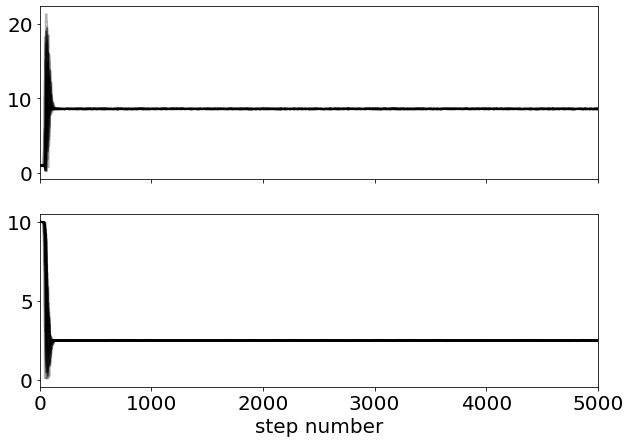

In [33]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain() # Vabbè lo avevamo già fatto

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    # Le catene dei vari walkers sono plottate una sopra l'altra.
    # È ben visibile la fase di termalizzazione
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [34]:
flat_samples = sampler.get_chain(discard=200, flat=True)

In [35]:
mcmc = np.zeros((ndim, 3))
# Per dare la confidenza dei parametri si usa l'interquartile range perché
# così non faccio assunzioni sulla distribuzione
for i in range(ndim):
  mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])
  # np.percentile estrae l'interquartile range a una certa percentuale
  # In mezzo otteniamo la mediana
mcmc

array([[8.56067036, 8.60035645, 8.63947401],
       [2.46587204, 2.47987844, 2.49414423]])

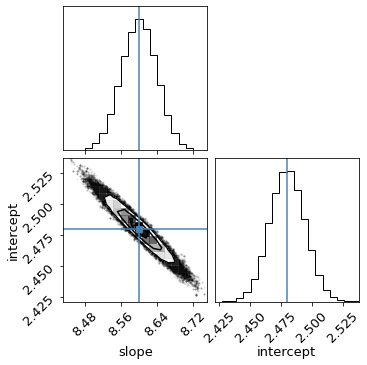

In [36]:
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["slope", "intercept"], truths=mcmc[:,1]);
    # truths=mcmc[:,1] serve per estrarre le mediane

# now try a broken power law with MCMC

New model: 

$F = \mathrm{flux}$

$t =  \mathrm{time}$

$T_b =  \mathrm{Time~of~break}$

$a_1, a_2, T_b, b:  \mathrm{model parameters}$


$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$


$b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2}) $


In [54]:
pars = ["b", "Tb", "a1", "a2"]
def bpl(theta, t):
  b, Tb, a1, a2 = theta
  return b - np.log10((t/Tb)**(-a1) + (t/Tb)**(-a2))

In [47]:
# Ora mi serve il tempo "vero", non log(t)
# Lo prendo da grbAGnu perché come prima guardo solo i dati "veri", non gli
# upper limits

x_nolog = grbAGnu.time.values

In [68]:
def log_prior(theta):
  b, Tb, a1, a2 = theta
  if Tb > 0:
    return 0    
  return -np.inf

In [69]:
def magn(log_flux):
  return 25 - 2.5 * log_flux

In [70]:
def log_likelihood(theta, x, y, yerr):

  return -np.sum(((bpl(theta, x) - y)**2) / yerr**2)

In [71]:
def nll(theta, x, y, yerr):
  # negative log likelihood. Vogliamo minimizzare ora, non massimizzare
  return -log_likelihood(theta, x, y, yerr)

In [72]:
ig = [12, 2000, 2.5, 2.5] # initial guess
soln = minimize(nll, ig, args=(x_nolog, y, s))
soln

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 217.4653145711489
        x: [ 1.505e+01  2.736e+02  2.146e+00  3.548e+00]
      nit: 89
      jac: [-3.376e-04  5.722e-06 -8.392e-05 -6.866e-05]
 hess_inv: [[ 2.412e-04  1.075e-04 -1.904e-04  7.557e-04]
            [ 1.075e-04  3.723e-04  2.052e-05  1.064e-03]
            [-1.904e-04  2.052e-05  3.472e-04 -6.220e-04]
            [ 7.557e-04  1.064e-03 -6.220e-04  4.964e-03]]
     nfev: 852
     njev: 168

In [104]:
# Male non converge

In [73]:
# Proviamo con un Monte Carlo

nwalkers = 32
ndim = len(ig)

pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [74]:
pos.shape

(32, 4)

In [75]:
# Ci serve la log_probability
# (in realtà avremmo potuto riusare tranquillamente la funzione omonima
# fatta per la regressione lineare)

def log_probability(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  return lp + log_likelihood(theta, x, y, yerr)

In [76]:
sampler_bpl = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                  args = (x_nolog, y, s))

In [77]:
sampler_bpl.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [01:21<00:00, 61.06it/s]


State([[ 15.05197859 275.85145995   2.13290326   3.59174909]
 [ 14.89977819 241.80123618   2.16314405   3.57940339]
 [ 14.9343657  249.03705061   2.16512511   3.6048536 ]
 [ 15.34105487 346.87106482   2.11693973   3.50193333]
 [ 14.63736    196.75050035   2.20392508   3.74681392]
 [ 14.8625658  233.08295038   2.15656583   3.68369267]
 [ 14.82993647 225.93377478   2.15152805   3.64051513]
 [ 15.39729131 368.29164898   2.0700206    3.43947093]
 [ 14.87086627 237.57544867   2.18282239   3.64424935]
 [ 15.42890234 377.23389017   2.09850674   3.40533791]
 [ 15.08512704 289.17078644   2.14139757   3.5360581 ]
 [ 14.93004999 247.42733411   2.14759832   3.57874638]
 [ 14.52906066 180.0704346    2.22339658   3.91572452]
 [ 15.22195186 314.01740002   2.11918736   3.53665617]
 [ 15.16751922 301.03000967   2.13075976   3.58833025]
 [ 14.91678825 247.09820719   2.17183949   3.54717448]
 [ 14.98504798 259.95563201   2.1517872    3.6554099 ]
 [ 15.19735786 316.4025409    2.13257394   3.40914301]
 [ 1

In [79]:
samples_bpl = sampler_bpl.get_chain()

Text(0.5, 0, 'step number')

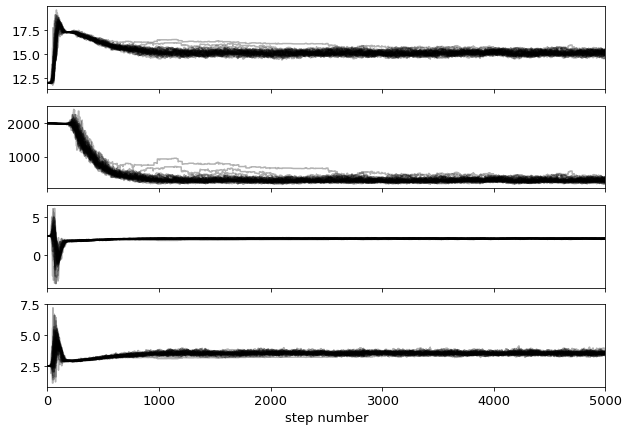

In [94]:
fig, axes = pl.subplots(ndim, figsize=(10,7), sharex=True)

for i in range(ndim):
  ax = axes[i]
  ax.plot(samples_bpl[:,:,i], "k", alpha=0.3)
  ax.set_xlim(0, len(samples))
  ax.yaxis.set_label_coords(-0.1, 0.5) # boohhh

axes[-1].set_xlabel("step number")

In [95]:
flat_samples_bpl = sampler_bpl.get_chain(discard=200,
                                         thin=15, flat=True)

In [96]:
flat_samples_bpl.shape

(10240, 4)

In [97]:
mcmc_bpl = np.zeros((ndim, 3))

for i in range(ndim):
  mcmc_bpl[i] = np.percentile(flat_samples_bpl[:,i], [16, 50, 84])

mcmc_bpl

array([[ 14.89583977,  15.14416033,  15.54528786],
       [241.6783332 , 296.24785146, 416.42216773],
       [  2.06736821,   2.1310389 ,   2.1726711 ],
       [  3.32998989,   3.49568126,   3.630817  ]])

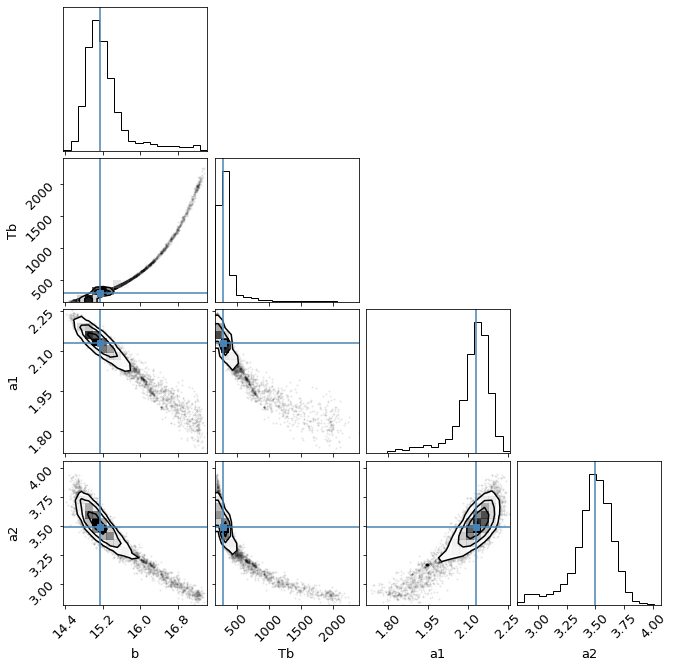

In [98]:
fig = corner.corner(flat_samples_bpl, labels=["b", "Tb", "a1", "a2"],
                    truths=mcmc_bpl[:, 1]);

Text(0.5, 0, 'log time (sec after explosion)')

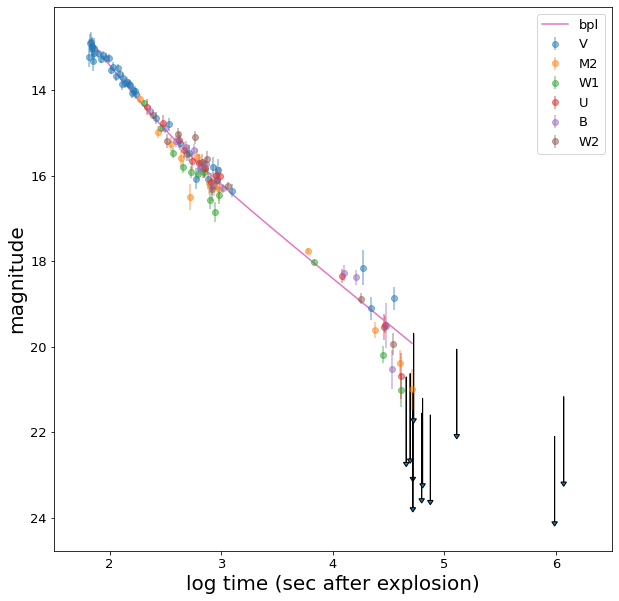

In [103]:
# Proviamo a plottare il fit sopra i dati

ax = pl.figure(figsize=(10,10)).add_subplot(111)

# INIZIO solito codice per plottare i punti

# plot the datapoints as above as errorbars
for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"],
                grbAG.loc[grbAG["filter"] == f, "magerr"],
                marker = "o", linestyle = "None", alpha = 0.5,
                label = str(f));

# plot the upperlimits as arrows 
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k');

# FINE plot punti

# Questa è la nuova x che useremo per valutare il fit
# Qui non abbiamo una sola retta quindi serve come minimo un linspace         
newx = np.linspace(grbAGnu.logtime.min(), grbAGnu.logtime.max(), 100)

# Prendiamo come risultati del Monte Carlo i valori mediani
results = mcmc_bpl[:, 1]

ax.plot(newx, bpl(results, 10**newx), label="bpl")
# Devo prendere 10**newx quando valuto bpl perché questa funzione vuole in
# input il tempo, non il log del tempo. Bisogna usare questo escamotage
# perché poi sull'asse x dobbiamo mettere il log del tempo.
# Fare due linspace (uno con estremi il log del tempo e uno con estremi il
# tempo) non funziona perché i punti di campionamento sarebbero diversi, col
# risultato che plotteremmo i punti nelle posizioni sbagliate

pl.legend()

pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.gca().invert_yaxis()

pl.xlabel("log time (sec after explosion)", fontsize=20)